# **Deep Learning Remote Sensing Classification Project**

<span style="color:red">*By Alexandre DELOIRE, Rémi JORGE, Jiayi HE - IG5 - Polytech Montpellier*</span>

## <span style="color:yellow">**I - Download the data**</span>

**Goal**

This template downloads the UCM data (both mono and multi-labels) in your local Colab environment.

Write the notebook in such a way that it fully runs from start to end without further intervention  
(i.e. do not change the directory structure manually in the mean time).

In [ ]:
import os
import zipfile

! git clone https://git.wur.nl/lobry001/ucmdata.git
os.chdir('ucmdata')

with zipfile.ZipFile('UCMerced_LandUse.zip', 'r') as zip_ref:
    zip_ref.extractall('UCMImages')

!mv UCMImages/UCMerced_LandUse/Images .
!rm -rf UCMImages README.md  UCMerced_LandUse.zip
!ls

os.chdir('..')

UCM_images_path = "Images/"
Multilabels_path = "LandUse_Multilabeled.txt"

## <span style="color:yellow">**II - Initialization**</span>


In this section, we begin by importing all the necessary libraries and modules, including `PyTorch` for model development and `torchvision` for data handling and transformations. This will also include defining key functions such as loading the data, training the model, testing its performance, and visualizing the results.

Additionally, we set up various hyperparameters that will be used during the training process, such as learning rate the number of epochs. These configurations ensure that the model is trained effectively and efficiently.

The core elements of this section include:
- **Data Loading**: Functions to load and preprocess the dataset.
- **Training and Testing**: Functions to handle the training loop, backpropagation, and model evaluation on the validation/test sets.
- **Visualization**: Code to display metrics, loss curves, and other relevant outputs during and after training.

This setup prepares the environment for running the deep learning experiments and evaluating the results.

### <span style="color:cyan">1) Imports

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split

### <span style="color:cyan"> 2) Load Data

In [20]:
# Define dataset paths
dataset_path = "./ucmdata/UCMImages/UCMerced_LandUse/Images"

# Define transformations for images
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=data_transforms)

# Split the dataset
train_size = int(0.7 * len(full_dataset))
test_size = int(0.2 * len(full_dataset))
valid_size = len(full_dataset) - train_size - test_size
train_dataset, test_dataset, valid_dataset = random_split(full_dataset, [train_size, test_size, valid_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)
valid_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

# Verify the classes
print(f"Classes: {full_dataset.classes}")
# Number of classes
print(f"Number of classes: {len(full_dataset.classes)}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}")


Classes: ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']
Number of classes: 21
Number of training samples: 1470
Number of testing samples: 420
Number of validation samples: 210


### <span style="color:cyan">3) Training Functions

#### a - Optimisation

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Loss function (Cross Entropy Loss for multi-class classification)
criterion = nn.CrossEntropyLoss()

Using device: cuda


In [22]:
def OptimizationStep(current_model):

    # Initialize the model, loss function, and optimizer
    # Send model to GPU if available
    model = current_model.to(device)

    # Optimizer (Adam optimizer)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    return model, optimizer

#### b - Training Functions

In [23]:
# Set a higher number of epochs
NUM_EPOCH = 1000  

# Number of epochs to wait for early stopping
PATIENCE = 50 

In [24]:
def train_one_epoch(model, optimizer):
    # --- Training Phase ---
    model.train()  # Set the model to training mode
    total_loss = 0.0
    correct = 0
    total = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the parameter gradients
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update the weights

        # Track loss and accuracy during training
        total_loss += loss.item() * batch_x.size(0)  # Accumulate batch loss
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

    avg_train_loss = total_loss / total
    train_accuracy = 100 * correct / total

    return avg_train_loss, train_accuracy

In [25]:
def evaluate_model(model):
    # --- Validation Phase ---
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for batch_x, batch_y in valid_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass (no gradient calculation)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            # Track loss and accuracy during validation
            val_loss += loss.item() * batch_x.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == batch_y).sum().item()
            total_val += batch_y.size(0)

    avg_val_loss = val_loss / total_val
    val_accuracy = 100 * correct_val / total_val

    return avg_val_loss, val_accuracy

In [26]:
def train_and_evaluate(model, optimizer, save=False):
    best_val_accuracy = 0.0
    early_stop_counter = 0

    train_accuracies = []
    val_accuracies = []
    train_loss = []
    val_loss = []

    best_model_path = 'best_model.pth'

    for epoch in range(NUM_EPOCH):

        start_time = time.time()
        avg_train_loss, train_accuracy = train_one_epoch(model, optimizer)
        end_time = time.time()

        print(f"\n\n----------------- Epoch [{epoch+1}/{NUM_EPOCH}] -------------------")
        print(f"\nTime taken for epoch: {end_time - start_time:.2f} sec")
        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

        avg_val_loss, val_accuracy = evaluate_model(model)
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_loss.append(avg_train_loss)
        val_loss.append(avg_val_loss)

        # --- Early Stopping and Saving the Best Model ---
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            if save:
                torch.save(model.state_dict(), best_model_path)  # Save the model if validation accuracy improves
                print(f" ---- > Model saved at epoch {epoch+1} with validation accuracy: {val_accuracy:.2f}%")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
        print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")

        # Stop training if early stopping criteria are met
        if early_stop_counter >= PATIENCE:
            print(f"Early stopping at epoch {epoch+1}. Validation accuracy stopped improving.")
            break

    print("Training complete. Best validation accuracy: {:.2f}%".format(best_val_accuracy))

    if save:
        print("Loading the best model from saved checkpoint...")
        model.load_state_dict(torch.load(best_model_path))

    return train_accuracies, train_loss, val_accuracies, val_loss, model

In [27]:
def initialize_and_train(model, save=False):
    print(f"Training model: {model.__class__.__name__}")
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    print(f"Number of layers: {len(list(model.children()))}")
    print(f"Architecture of the model: \n{model}\n")
    print(f"\nInitialization...")
    model, optimizer = OptimizationStep(model)
    print(f"Initialization complete. Starting training...\n")
    return train_and_evaluate(model, optimizer, save=save)

#### c - Display Result

In [28]:
def show_training_result(train_accuracies, train_loss, val_accuracies, val_loss):
    
    epochs = range(1, len(train_accuracies) + 1)

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # accuracies graph
    ax1.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    ax1.plot(epochs, val_accuracies, label='Val Accuracy', marker='o')
    ax1.set_title('Train & Val Accuracies')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # loss graph
    ax2.plot(epochs, train_loss, label='Train Loss', marker='o')
    ax2.plot(epochs, val_loss, label='Val Loss', marker='o')
    ax2.set_title('Train & Val Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    # Show
    plt.tight_layout()
    plt.show()

    print(f"----------------- Training Results -------------------")

    # Print the final results
    print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
    print(f"Final Training Loss: {train_loss[-1]:.4f}")
    print(f"Final Validation Loss: {val_loss[-1]:.4f}")

    # Print the best results
    best_val_accuracy = max(val_accuracies)
    best_val_accuracy_epoch = val_accuracies.index(best_val_accuracy) + 1
    print(f"\nBest Validation Accuracy: {best_val_accuracy:.2f}% at epoch {best_val_accuracy_epoch}")

In [29]:
def show_comparison_result(train_accuracies_list, val_accuracies_list):
    num_models = len(train_accuracies_list)

    assert num_models == len(val_accuracies_list), "Le nombre de tableaux de train et de validation doit être le même."
    
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    for i in range(num_models):
        train_accuracies = train_accuracies_list[i]
        val_accuracies = val_accuracies_list[i]
        epochs = range(1, len(train_accuracies) + 1)
        
        ax1.plot(epochs, train_accuracies, label=f'Train Accuracy {i+1}', marker='o')
        
        ax2.plot(epochs, val_accuracies, label=f'Val Accuracy {i+1}', marker='o')

    ax1.set_title('Train Accuracies')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    ax2.set_title('Val Accuracies')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"----------------- Training Results -------------------")

    for i in range(num_models):
        best_val_accuracy = max(val_accuracies_list[i])
        best_val_accuracy_epoch = val_accuracies_list[i].index(best_val_accuracy) + 1
        print(f"\nBest Validation Accuracy {i+1}: {best_val_accuracy:.2f}% at epoch {best_val_accuracy_epoch}")


### <span style="color:cyan"> 4) Testing Functions

In [30]:
def test_model(model):
    # --- Test Phase ---
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    # matrix num_class x num_class of classification
    classification_results = np.zeros((len(full_dataset.classes), len(full_dataset.classes)))

    print("----------------- Testing -------------------")

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass (aucun calcul de gradient)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            # Suivi de la perte et de l'exactitude
            test_loss += loss.item() * batch_x.size(0)
            _, predicted = torch.max(outputs, 1)

            # classification matrix
            for i in range(len(predicted)):
                classification_results[batch_y[i]][predicted[i]] += 1

            correct_test += (predicted == batch_y).sum().item()
            total_test += batch_y.size(0)

    avg_test_loss = test_loss / total_test if total_test != 0 else 0
    test_accuracy = 100 * correct_test / total_test if total_test != 0 else 0

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Correctly classified samples: {correct_test}/{total_test}")

    return avg_test_loss, test_accuracy, classification_results


In [31]:
def plot_confusion_matrix(classification_results, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(classification_results, annot=True, fmt="g", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Classes")
    plt.ylabel("Actual Classes")
    plt.title("Confusion Matrix")
    plt.show()


In [32]:
def plot_correct_predictions(classification_results, class_names):
    correct_per_class = np.diag(classification_results) 
    
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, correct_per_class, color='green')
    plt.xlabel("Classes")
    plt.ylabel("Number of correct predictions")
    plt.title("Correct predictions by class")
    plt.xticks(rotation=45, ha="right")
    plt.show()


In [33]:
def plot_classification_errors(classification_results, class_names):
    total_per_class = classification_results.sum(axis=1)
    correct_per_class = np.diag(classification_results)
    errors_per_class = total_per_class - correct_per_class
    
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, errors_per_class, color='red')
    plt.xlabel("Classes")
    plt.ylabel("Number of classification errors")
    plt.title("Classification errors by class")
    plt.xticks(rotation=45, ha="right")
    plt.show()


In [34]:
def plot_overall_accuracy(classification_results):
    total_correct = np.diag(classification_results).sum()
    total = classification_results.sum()
    incorrect = total - total_correct
    
    labels = ['Correct', 'Incorrect']
    sizes = [total_correct, incorrect]
    colors = ['green', 'red']
    
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, counterclock=False)
    plt.title("Distribution of correct and incorrect predictions")
    plt.show()


In [35]:
def plot_correct_incorrect_predictions(classification_results, class_names):
    # Nombre total de prédictions par classe (somme des lignes)
    total_per_class = classification_results.sum(axis=1)
    
    # Prédictions correctes par classe (diagonale de la matrice)
    correct_per_class = np.diag(classification_results)
    
    # Erreurs par classe (somme des éléments hors diagonale par classe)
    incorrect_per_class = total_per_class - correct_per_class
    
    # Convertir en proportion (pourcentages)
    correct_percentage = correct_per_class / total_per_class * 100
    incorrect_percentage = incorrect_per_class / total_per_class * 100
    
    # Plot histogramme empilé
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, correct_percentage, color='green', label='Correct')
    plt.bar(class_names, incorrect_percentage, bottom=correct_percentage, color='red', label='Incorrect')
    
    plt.xlabel("Classes")
    plt.ylabel("Percentage of predictions (%)")
    plt.title("Correct and incorrect predictions by class (True Negative)")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.show()

In [36]:
def calculate_false_positives(classification_results):
    # Faux positifs : somme de chaque colonne (prédictions faites pour cette classe) sans la diagonale
    false_positives = np.around(100 * (classification_results.sum(axis=0) - np.diag(classification_results)) / classification_results.sum(axis=0), 2)
    
    return false_positives

def display_false_positives(classification_results, class_names):
    false_positives = calculate_false_positives(classification_results)
    
    print("\nFalse positives by class:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {false_positives[i]}")
    
    # Plotting faux positifs
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, false_positives, color='orange', label='Faux positifs')
    plt.xlabel("Classes")
    plt.ylabel("False positives (%)")
    plt.title("False positives by class")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.show()



## <span style="color:yellow">**III - Single Label**</span>

In this section, we present the implementation and evaluation of our initial Convolutional Neural Network (CNN) designed for single-label classification. The goal is to classify each image into one of 21 land-use categories from the UCM dataset.

The process is as follows:
- **Model Architecture**: We define the structure of the initial CNN, consisting of convolutional layers, max-pooling, and fully connected layers. The architecture is kept simple to establish a baseline for comparison with more complex models later on.
- **Training the Model**: We use the training set to optimize the model parameters, following a standard training loop with forward and backward propagation.
- **Testing**: After training, we evaluate the model on the test sets.
- **Visualization**: The section also includes plots showing the testing accuracy, providing insights into the model's learning behavior.

This section establishes a baseline performance for single-label classification, setting the stage for improvements using more advanced techniques in subsequent sections.

### <span style="color:cyan"> 1) Model Architecture

In [19]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=21):
        super(CNNModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), # 32x256x256
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x128x128
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # 64x128x128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64x64x64
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # 128x64x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x32x32
            nn.Flatten()
        )

        self.num_features = 128 * 32 * 32

        self.classifier = nn.Sequential(
            nn.Linear(self.num_features, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        
        x = self.features(x)

        x = self.classifier(x)

        return x

### <span style="color:cyan"> 2) Training the Model

In [20]:
NUM_EPOCH = 60
PATIENCE = 20
train_accuracies_single,\
train_loss_single,\
val_accuracies_single,\
val_loss_single,\
model_single = initialize_and_train(CNNModel(), save=True)

Training model: CNNModel
Number of parameters: 67213397
Number of layers: 2
Architecture of the model: 
CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=131072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=21, bias=True)
  )
)


Initialization...
Initialization complete. Starting training...



----------------- Epoch [1/60] -------------

C:\Users\remij\AppData\Local\Temp\ipykernel_17388\2968688044.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


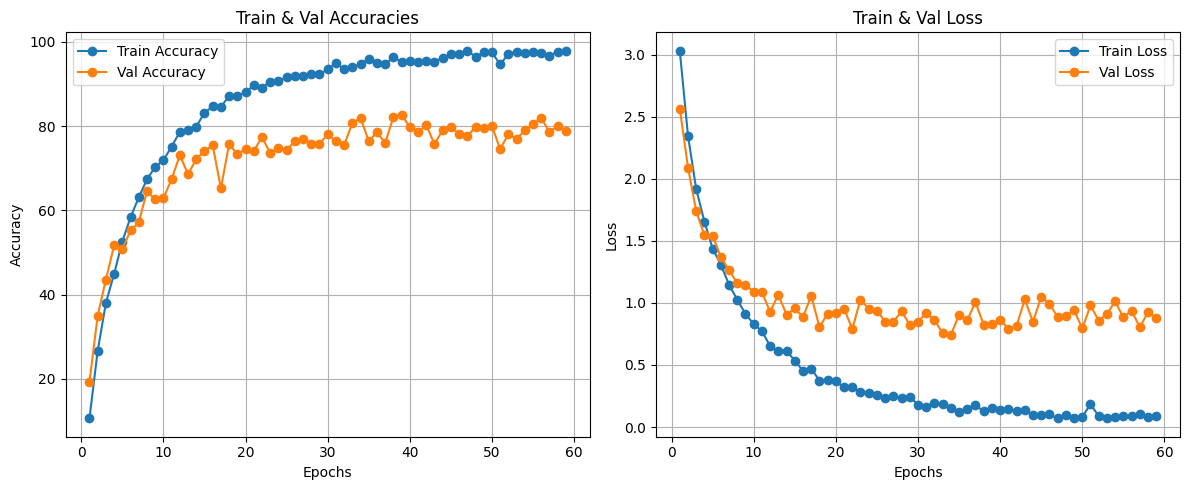

----------------- Training Results -------------------
Final Training Accuracy: 97.89%
Final Validation Accuracy: 78.81%
Final Training Loss: 0.0919
Final Validation Loss: 0.8786

Best Validation Accuracy: 82.62% at epoch 39


In [21]:
show_training_result(train_accuracies_single, train_loss_single, val_accuracies_single, val_loss_single)

### <span style="color:cyan">3) Testing Model

In [39]:
avg_test_loss, test_accuracy, classification_results = test_model(model_single)

----------------- Testing -------------------
Test Loss: 0.8255, Test Accuracy: 83.81%
Correctly classified samples: 352/420


### <span style="color:cyan"> 4) Visualization

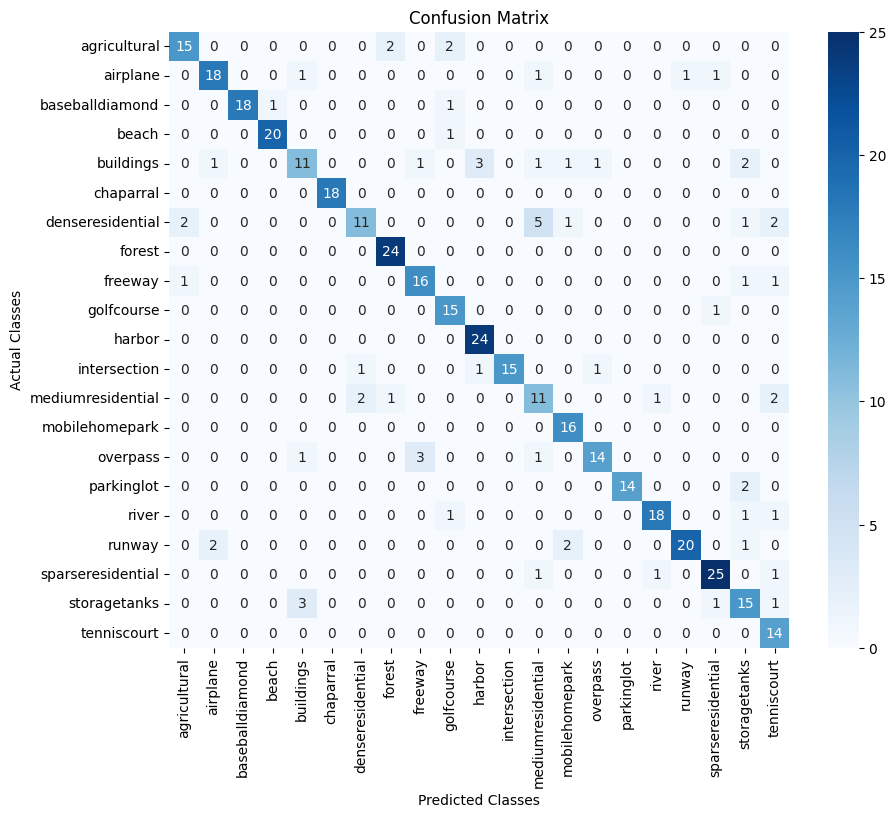

In [40]:
class_names = full_dataset.classes
plot_confusion_matrix(classification_results, class_names)

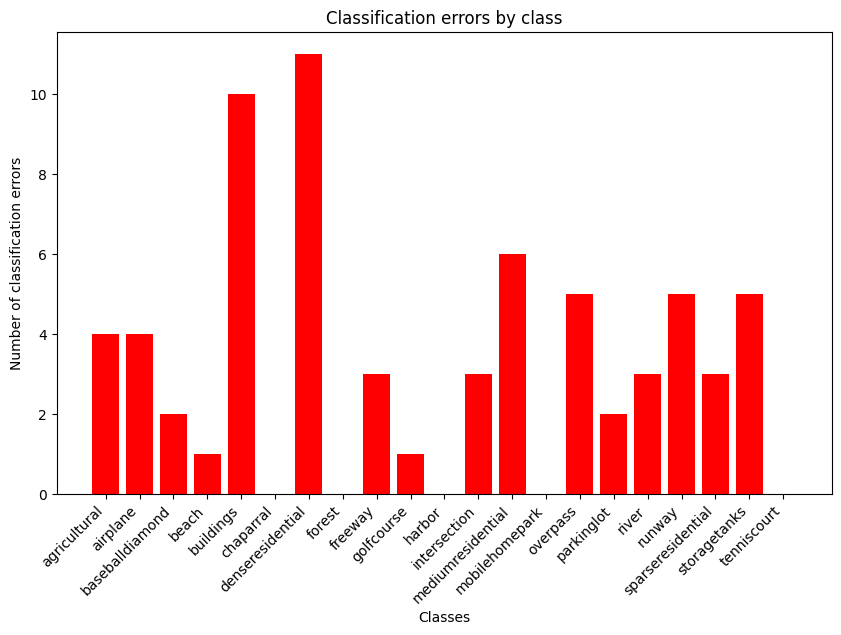

In [41]:
plot_classification_errors(classification_results, class_names)

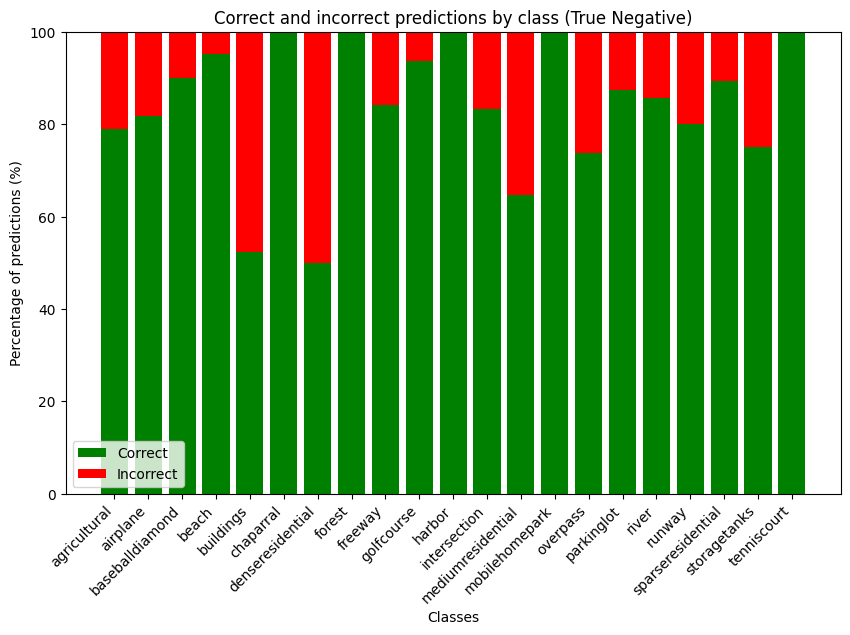

In [42]:
plot_correct_incorrect_predictions(classification_results, class_names)


False positives by class:
agricultural: 16.67
airplane: 14.29
baseballdiamond: 0.0
beach: 4.76
buildings: 31.25
chaparral: 0.0
denseresidential: 21.43
forest: 11.11
freeway: 20.0
golfcourse: 25.0
harbor: 14.29
intersection: 0.0
mediumresidential: 45.0
mobilehomepark: 20.0
overpass: 12.5
parkinglot: 0.0
river: 10.0
runway: 4.76
sparseresidential: 10.71
storagetanks: 34.78
tenniscourt: 36.36


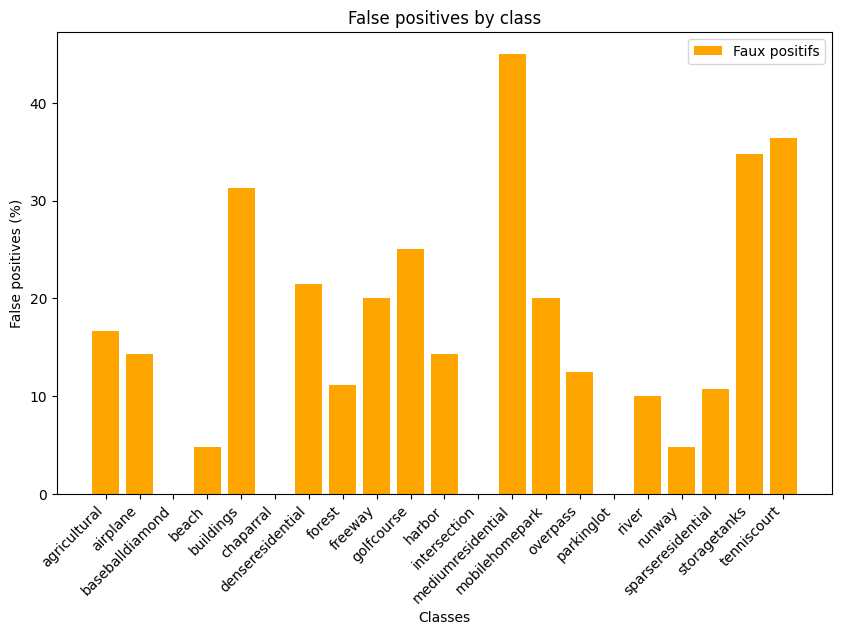

In [44]:
display_false_positives(classification_results, class_names)

## <span style="color:yellow">**IV - Impact of Parameters**</span>

In this section, we explore how different parameters, dropout, kernel size and data augmentation techniques, affect the model's performance. By adjusting these parameters, we aim to improve the accuracy and generalization of the initial model.


### <span style="color:cyan">1) Number of Channels

#### a - High

In [108]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=21):
        super(CNNModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1), # 64x256x256
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64x128x128

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # 128x128x128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x64x64

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), # 256x64x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 256x32x32
            
            nn.Flatten()
        )

        self.num_features = 256 * 32 * 32

        self.classifier = nn.Sequential(
            nn.Linear(self.num_features, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        
        x = self.features(x)

        x = self.classifier(x)

        return x

In [109]:
NUM_EPOCH = 50
PATIENCE = 20
train_accuracies_41a, train_loss_41a, val_accuracies_41a, val_loss_41a, _ = initialize_and_train(CNNModel())

Training model: CNNModel
Number of parameters: 134599829
Number of layers: 2
Architecture of the model: 
CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=262144, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=21, bias=True)
  )
)


Initialization...
Initialization complete. Starting training...



----------------- Epoch [1/50] ----------

#### b - Low

In [67]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=21):
        super(CNNModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1), # 16x256x256
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16x128x128

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1), # 32x128x128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x64x64

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # 64x64x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64x32x32
            
            nn.Flatten()
        )

        self.num_features = 64 * 32 * 32

        self.classifier = nn.Sequential(
            nn.Linear(self.num_features, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        
        x = self.features(x)

        x = self.classifier(x)

        return x

In [68]:
NUM_EPOCH = 50
PATIENCE = 20
train_accuracies_41b, train_loss_41b, val_accuracies_41b, val_loss_41b, _ = initialize_and_train(CNNModel())

Training model: CNNModel
Number of parameters: 33589301
Number of layers: 2
Architecture of the model: 
CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=65536, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=21, bias=True)
  )
)


Initialization...
Initialization complete. Starting training...



----------------- Epoch [1/50] ---------------

#### c - Compararison

In [ ]:
show_comparison_result([train_accuracies_single, train_accuracies_41a, train_accuracies_41b],
                       [val_accuracies_single, val_accuracies_41a, val_accuracies_41b])

### <span style="color:cyan">2) BatchNorm

In [64]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=21):
        super(CNNModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), # 32x256x256
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x128x128
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # 64x128x128
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64x64x64
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # 128x64x64
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x32x32
            nn.Flatten()
        )

        self.num_features = 128 * 32 * 32

        self.classifier = nn.Sequential(
            nn.Linear(self.num_features, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        
        x = self.features(x)

        x = self.classifier(x)

        return x

In [65]:
NUM_EPOCH = 50
PATIENCE = 20
train_accuracies_42a, train_loss_42a, val_accuracies_42a, val_loss_42a, _ = initialize_and_train(CNNModel())

Training model: CNNModel
Number of parameters: 67213845
Number of layers: 2
Architecture of the model: 
CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Se

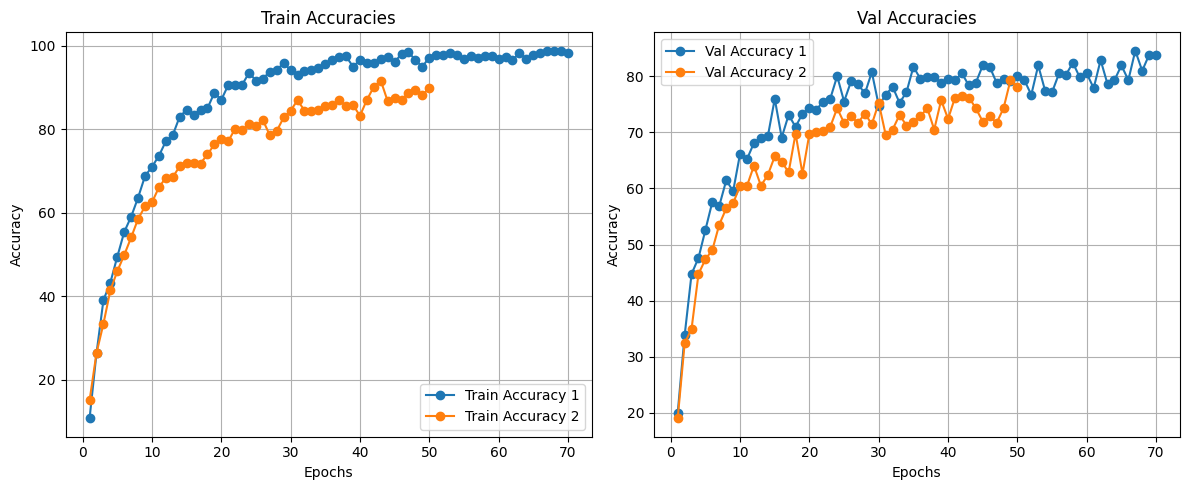

----------------- Training Results -------------------

Best Validation Accuracy 1: 84.52% at epoch 67

Best Validation Accuracy 2: 79.29% at epoch 49


In [66]:
show_comparison_result([train_accuracies_single, train_accuracies_42a], [val_accuracies_single, val_accuracies_42a])

### <span style="color:cyan">3) Number of Layers

#### a - 2 Layers 

In [23]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=21):
        super(CNNModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), # 32x256x256
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x128x128

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # 64x128x128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64x64x64

            nn.Flatten()
        )

        self.num_features = 64 * 64 * 64

        self.classifier = nn.Sequential(
            nn.Linear(self.num_features, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        
        x = self.features(x)

        x = self.classifier(x)

        return x

In [24]:
NUM_EPOCH = 50
PATIENCE = 20
train_accuracies_43a, train_loss_43a, val_accuracies_43a, val_loss_43a, _ = initialize_and_train(CNNModel())

Training model: CNNModel
Number of parameters: 134248405
Number of layers: 2
Architecture of the model: 
CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=262144, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=21, bias=True)
  )
)


Initialization...
Initialization complete. Starting training...



----------------- Epoch [1/50] -------------------

Time taken for epoch: 11.16 sec
Train Loss: 5.1180, Train Accuracy: 7.76%
Validation Loss: 2.9645, Validation Accuracy: 8.10%
Best Validation Accuracy: 8.10%


-------

#### b - 4 Layers

In [25]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=21):
        super(CNNModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), # 32x256x256
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x128x128

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # 64x128x128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64x64x64

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # 128x64x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x32x32

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), # 256x32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 256x16x16

            nn.Flatten()
        )

        self.num_features = 256 * 16 * 16

        self.classifier = nn.Sequential(
            nn.Linear(self.num_features, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        
        x = self.features(x)

        x = self.classifier(x)

        return x

In [26]:
NUM_EPOCH = 50
PATIENCE = 20
train_accuracies_43b, train_loss_43b, val_accuracies_43b, val_loss_43b, _ = initialize_and_train(CNNModel())

Training model: CNNModel
Number of parameters: 33954133
Number of layers: 2
Architecture of the model: 
CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=65536, out_features=512, bias=True)
    (1): ReLU()
 

#### c - Comparison

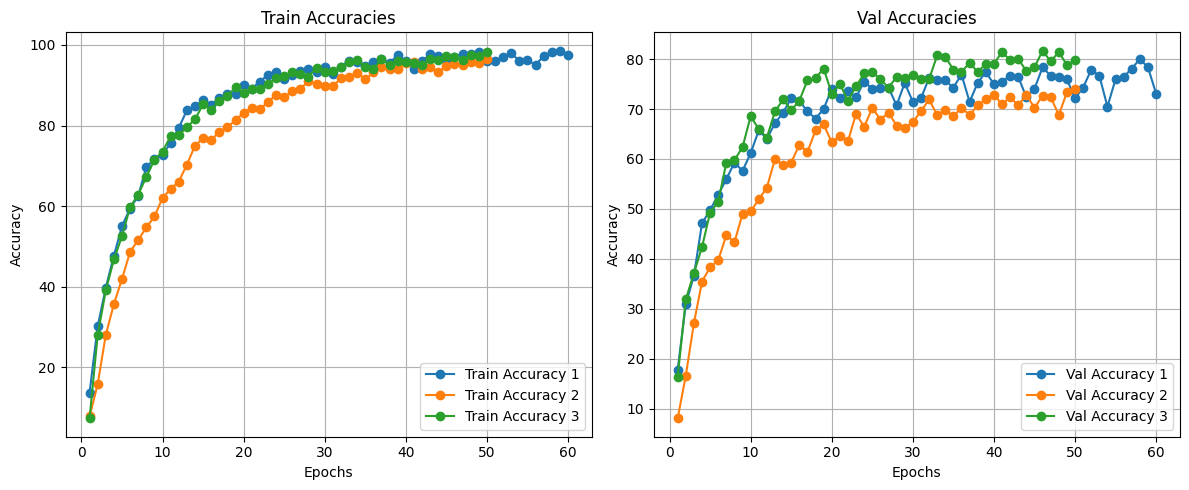

----------------- Training Results -------------------

Best Validation Accuracy 1: 80.00% at epoch 58

Best Validation Accuracy 2: 74.05% at epoch 50

Best Validation Accuracy 3: 81.67% at epoch 46


In [27]:
show_comparison_result([train_accuracies_single, train_accuracies_43a, train_accuracies_43b], [val_accuracies_single, val_accuracies_43a, val_accuracies_43b])

### <span style="color:cyan">4) Kernel Size

In [31]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=21):
        super(CNNModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2), # 32x256x256
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x128x128

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # 64x128x128
            nn.MaxPool2d(kernel_size=2, stride=2), # 64x64x64

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # 128x64x64
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x32x32
            
            nn.Flatten()
        )

        self.num_features = 128 * 32 * 32

        self.classifier = nn.Sequential(
            nn.Linear(self.num_features, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        
        x = self.features(x)

        x = self.classifier(x)

        return x

In [32]:
NUM_EPOCH = 50
PATIENCE = 20
train_accuracies_44a, train_loss_44a, val_accuracies_44a, val_loss_44a, _ = initialize_and_train(CNNModel())

Training model: CNNModel
Number of parameters: 67214933
Number of layers: 2
Architecture of the model: 
CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=131072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=21, bias=True)
  )
)


Initialization...
Initialization complete. Starting training...



----------------- Epoch [1/50] -------------------

Time taken for epoch: 6.99 sec
Train Los

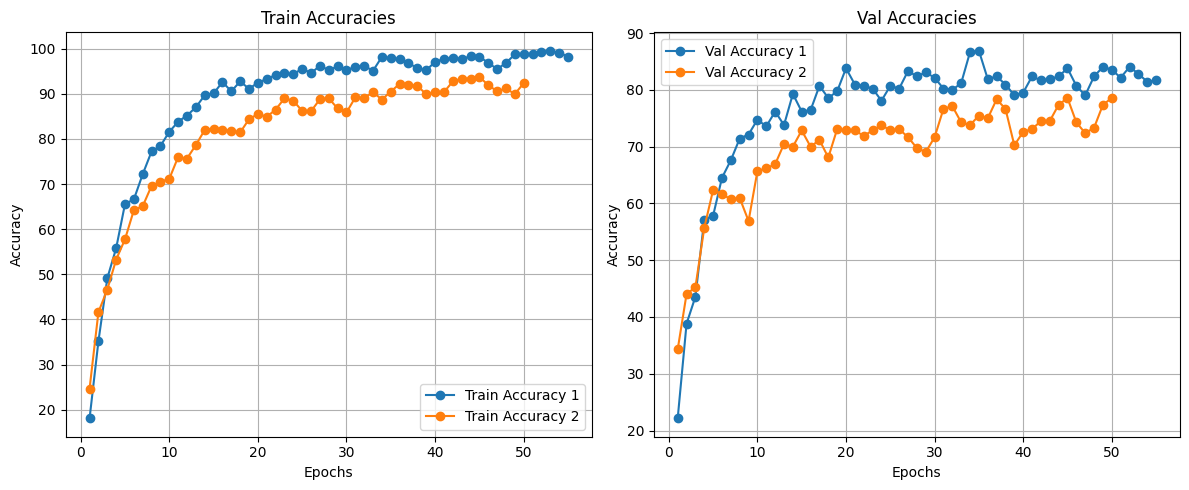

----------------- Training Results -------------------

Best Validation Accuracy 1: 86.90% at epoch 35

Best Validation Accuracy 2: 78.57% at epoch 45


In [33]:
show_comparison_result([train_accuracies_single, train_accuracies_44a], [val_accuracies_single, val_accuracies_44a])

### <span style="color:cyan">5) ReLu

In [28]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=21):
        super(CNNModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten()
        )

        self.num_features = 128 * 32 * 32

        self.classifier = nn.Sequential(
            nn.Linear(self.num_features, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        
        x = self.features(x)

        x = self.classifier(x)

        return x

In [29]:
NUM_EPOCH = 50
PATIENCE = 20
train_accuracies_45a, train_loss_45a, val_accuracies_45a, val_loss_45a, _ = initialize_and_train(CNNModel())

Training model: CNNModel
Number of parameters: 67213397
Number of layers: 2
Architecture of the model: 
CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=131072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=21, bias=True)
  )
)


Initialization...
Initialization complete. Starting training...



----------------- Epoch [1/50] -------------------

Time taken for epoch: 6.59 sec
Train Los

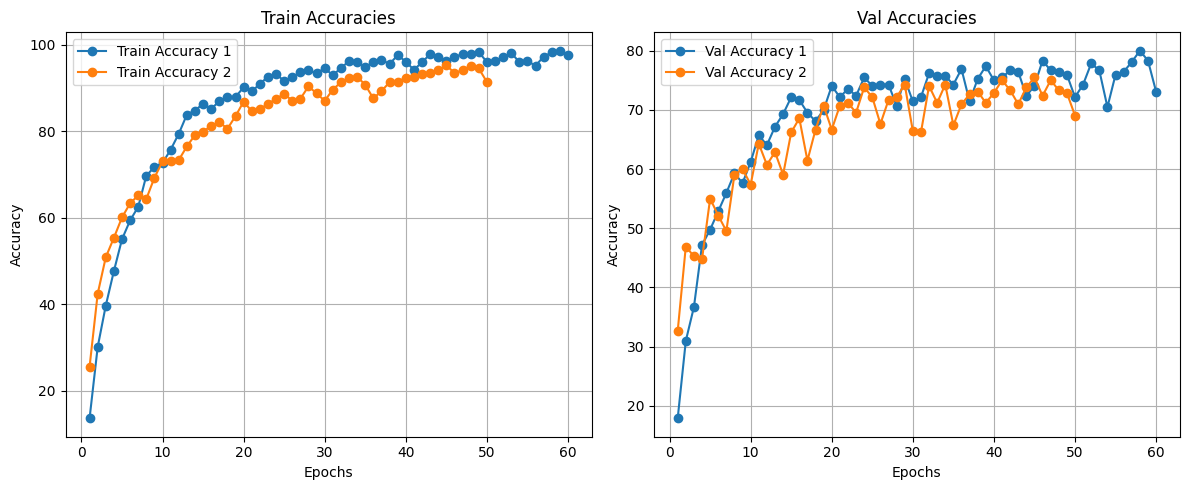

----------------- Training Results -------------------

Best Validation Accuracy 1: 80.00% at epoch 58

Best Validation Accuracy 2: 75.48% at epoch 45


In [30]:
show_comparison_result([train_accuracies_single, train_accuracies_45a], [val_accuracies_single, val_accuracies_45a])

### <span style="color:cyan">6) Dropout

In [27]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=21):
        super(CNNModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), # 32x256x256
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x128x128
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # 64x128x128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64x64x64
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # 128x64x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x32x32
            nn.Flatten()
        )

        self.num_features = 128 * 32 * 32

        self.classifier = nn.Sequential(
            nn.Linear(self.num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        
        x = self.features(x)

        x = self.classifier(x)

        return x

In [28]:
NUM_EPOCH = 75
PATIENCE = 20
train_accuracies_46a, train_loss_46a, val_accuracies_46a, val_loss_46a, _ = initialize_and_train(CNNModel())

Training model: CNNModel
Number of parameters: 67213397
Number of layers: 2
Architecture of the model: 
CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=131072, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=21, bias=True)
  )
)


Initialization...
Initialization complete. Starting training...



-----

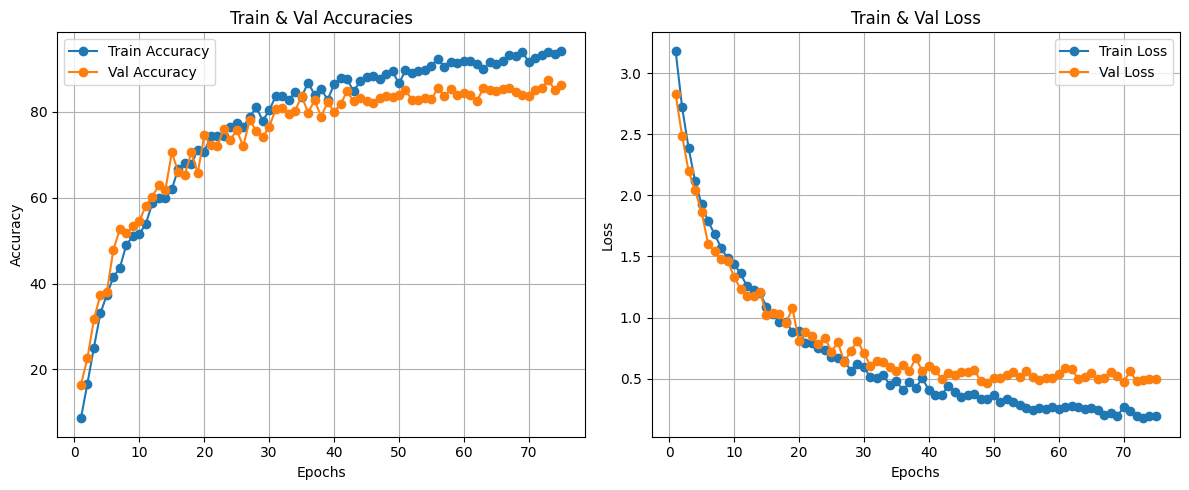

----------------- Training Results -------------------
Final Training Accuracy: 94.15%
Final Validation Accuracy: 86.19%
Final Training Loss: 0.1920
Final Validation Loss: 0.4959

Best Validation Accuracy: 87.38% at epoch 73


In [29]:
show_training_result(train_accuracies_46a, train_loss_46a, val_accuracies_46a, val_loss_46a)

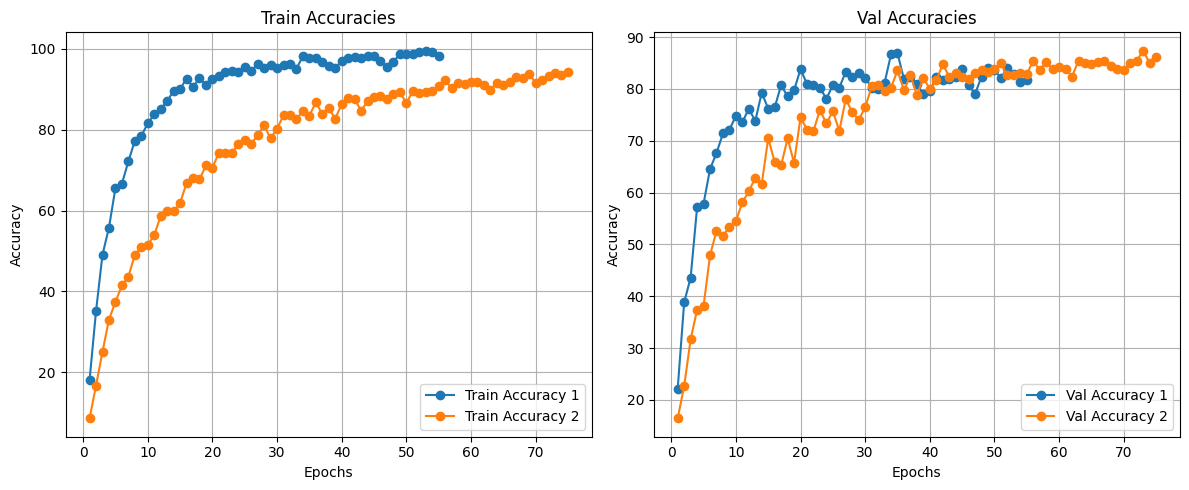

----------------- Training Results -------------------

Best Validation Accuracy 1: 86.90% at epoch 35

Best Validation Accuracy 2: 87.38% at epoch 73


In [30]:
show_comparison_result([train_accuracies_single, train_accuracies_46a], [val_accuracies_single, val_accuracies_46a])

In [ ]:
test_model(model_single)

### <span style="color:cyan">7) Number of Convolution

In [21]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=21):
        super(CNNModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), # 32x256x256
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1), # 32x256x256
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x128x128
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # 64x128x128
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x64x64
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # 128x64x64
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x32x32
            nn.Flatten()
        )

        self.num_features = 128 * 32 * 32

        self.classifier = nn.Sequential(
            nn.Linear(self.num_features, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        
        x = self.features(x)

        x = self.classifier(x)

        return x

In [22]:
NUM_EPOCH = 50
PATIENCE = 20
train_accuracies_47a, train_loss_47a, val_accuracies_47a, val_loss_47a, _ = initialize_and_train(CNNModel())

Training model: CNNModel
Number of parameters: 67407157
Number of layers: 2
Architecture of the model: 
CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=131

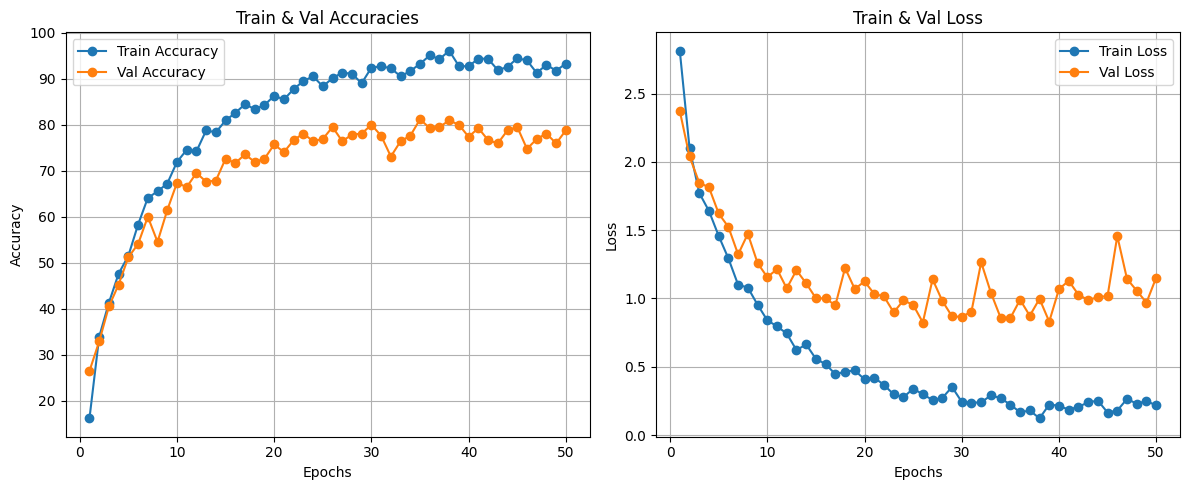

----------------- Training Results -------------------
Final Training Accuracy: 93.33%
Final Validation Accuracy: 78.81%
Final Training Loss: 0.2163
Final Validation Loss: 1.1528

Best Validation Accuracy: 81.19% at epoch 35


In [23]:
show_training_result(train_accuracies_47a, train_loss_47a, val_accuracies_47a, val_loss_47a)

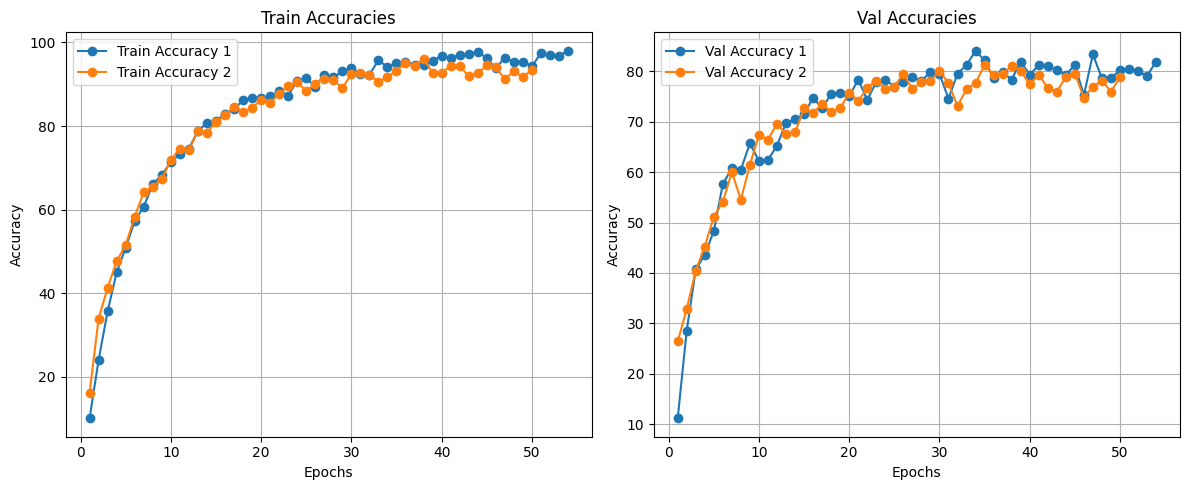

----------------- Training Results -------------------

Best Validation Accuracy 1: 84.05% at epoch 34

Best Validation Accuracy 2: 81.19% at epoch 35


In [24]:
show_comparison_result([train_accuracies_single, train_accuracies_47a], [val_accuracies_single, val_accuracies_47a])

### <span style="color:cyan">8) Model optimized

In [40]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=21):
        super(CNNModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), # 32x256x256
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x128x128
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # 64x128x128
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64x64x64
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # 128x64x64
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x32x32
            nn.Flatten()
        )

        self.num_features = 128 * 32 * 32

        self.classifier = nn.Sequential(
            nn.Linear(self.num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        
        x = self.features(x)

        x = self.classifier(x)

        return x

In [37]:
NUM_EPOCH = 500
PATIENCE = 30
train_accuracies_48a, train_loss_48a, val_accuracies_48a, val_loss_48a, model_48a = initialize_and_train(CNNModel())

Training model: CNNModel
Number of parameters: 67213845
Number of layers: 2
Architecture of the model: 
CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Se

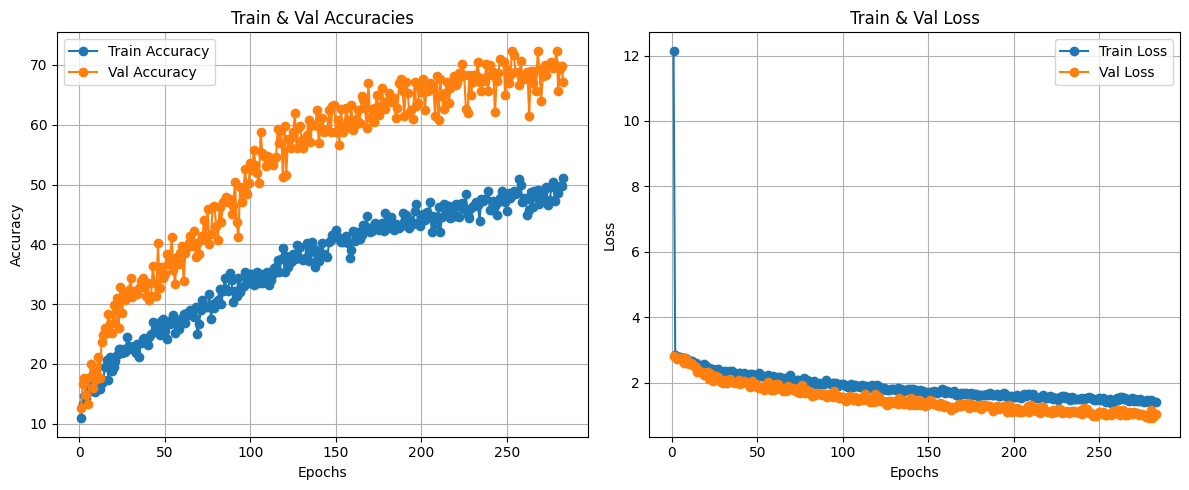

----------------- Training Results -------------------
Final Training Accuracy: 51.02%
Final Validation Accuracy: 67.14%
Final Training Loss: 1.4210
Final Validation Loss: 1.0466

Best Validation Accuracy: 72.38% at epoch 253


In [38]:
show_training_result(train_accuracies_48a, train_loss_48a, val_accuracies_48a, val_loss_48a)

In [41]:
NUM_EPOCH = 1000
PATIENCE = 75
train_accuracies_48b, train_loss_48b, val_accuracies_48b, val_loss_48b, model_48b = initialize_and_train(CNNModel())

Training model: CNNModel
Number of parameters: 67213845
Number of layers: 2
Architecture of the model: 
CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Se

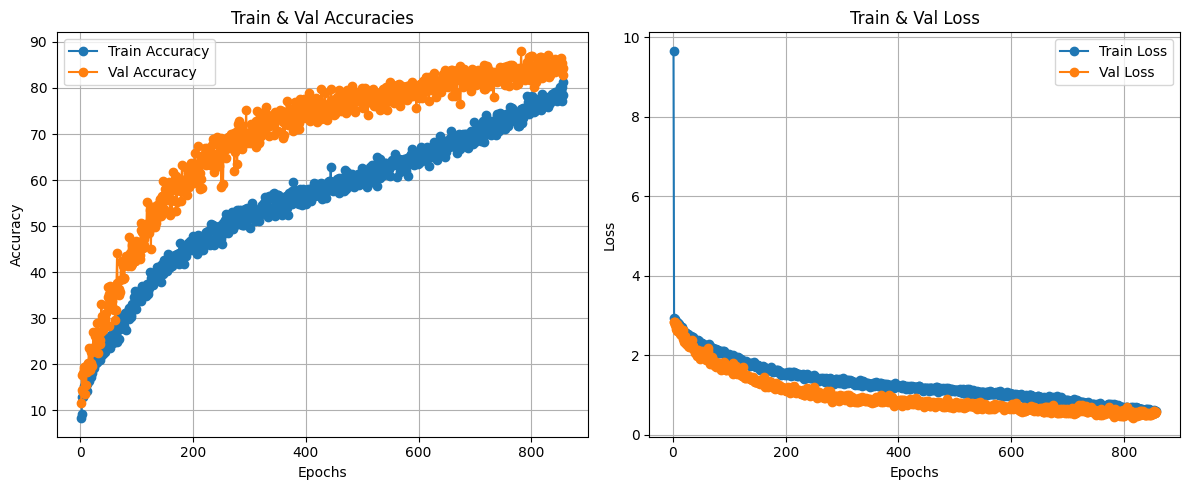

----------------- Training Results -------------------
Final Training Accuracy: 78.37%
Final Validation Accuracy: 82.86%
Final Training Loss: 0.6006
Final Validation Loss: 0.5783

Best Validation Accuracy: 88.10% at epoch 782


In [42]:
show_training_result(train_accuracies_48b, train_loss_48b, val_accuracies_48b, val_loss_48b)

In [46]:
test_model(model_48b)

----------------- Testing -------------------
Test Loss: 0.5216, Test Accuracy: 85.95%
Correctly classified samples: 361/420


(0.521572292347749,
 85.95238095238095,
 array([[17.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0., 23.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 19.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 11.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
          1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 24.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0., 17.,  0.,  0.,  0.,  0.,  0.,  0.,
          1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 19.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,

### <span style="color:cyan">9) Data importance

#### a - Classic : without transformation

In [22]:
# Define dataset paths
dataset_path = "./ucmdata/UCMImages/UCMerced_LandUse/Images"

# Define transformations for images (Resize, Normalize, Convert to Tensor)
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=data_transforms)

# Split the dataset
train_size = int(0.7 * len(full_dataset))
test_size = int(0.2 * len(full_dataset))
valid_size = len(full_dataset) - train_size - test_size
train_dataset, test_dataset, valid_dataset = random_split(full_dataset, [train_size, test_size, valid_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)
valid_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

# Verify the classes
print(f"Classes: {full_dataset.classes}")
# Number of classes
print(f"Number of classes: {len(full_dataset.classes)}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}")


Classes: ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']
Number of classes: 21
Number of training samples: 1470
Number of testing samples: 420
Number of validation samples: 210


In [23]:
NUM_EPOCH = 50
PATIENCE = 20
train_accuracies_49a, train_loss_49a, val_accuracies_49a, val_loss_49a, _ = initialize_and_train(CNNModel())

Training model: CNNModel
Number of parameters: 67213397
Number of layers: 2
Architecture of the model: 
CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=131072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=21, bias=True)
  )
)


Initialization...
Initialization complete. Starting training...



----------------- Epoch [1/50] -------------

#### b - With Norm

In [24]:
# Define dataset paths
dataset_path = "./ucmdata/UCMImages/UCMerced_LandUse/Images"

# Define transformations for images (Resize, Normalize, Convert to Tensor)
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=data_transforms)

# Split the dataset
train_size = int(0.7 * len(full_dataset))
test_size = int(0.2 * len(full_dataset))
valid_size = len(full_dataset) - train_size - test_size
train_dataset, test_dataset, valid_dataset = random_split(full_dataset, [train_size, test_size, valid_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)
valid_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

# Verify the classes
print(f"Classes: {full_dataset.classes}")
# Number of classes
print(f"Number of classes: {len(full_dataset.classes)}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}")

Classes: ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']
Number of classes: 21
Number of training samples: 1470
Number of testing samples: 420
Number of validation samples: 210


In [25]:
NUM_EPOCH = 50
PATIENCE = 20
train_accuracies_49b, train_loss_49b, val_accuracies_49b, val_loss_49b, _ = initialize_and_train(CNNModel())

Training model: CNNModel
Number of parameters: 67213397
Number of layers: 2
Architecture of the model: 
CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=131072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=21, bias=True)
  )
)


Initialization...
Initialization complete. Starting training...



----------------- Epoch [1/50] -------------

#### c - Flip transformations

In [26]:
# Define dataset paths
dataset_path = "./ucmdata/UCMImages/UCMerced_LandUse/Images"

# Define transformations for images (Resize, Normalize, Convert to Tensor)
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=data_transforms)

# Split the dataset
train_size = int(0.7 * len(full_dataset))
test_size = int(0.2 * len(full_dataset))
valid_size = len(full_dataset) - train_size - test_size
train_dataset, test_dataset, valid_dataset = random_split(full_dataset, [train_size, test_size, valid_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)
valid_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

# Verify the classes
print(f"Classes: {full_dataset.classes}")
# Number of classes
print(f"Number of classes: {len(full_dataset.classes)}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}")

Classes: ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']
Number of classes: 21
Number of training samples: 1470
Number of testing samples: 420
Number of validation samples: 210


In [27]:
NUM_EPOCH = 50
PATIENCE = 20
train_accuracies_49c, train_loss_49c, val_accuracies_49c, val_loss_49c, _ = initialize_and_train(CNNModel())

Training model: CNNModel
Number of parameters: 67213397
Number of layers: 2
Architecture of the model: 
CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=131072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=21, bias=True)
  )
)


Initialization...
Initialization complete. Starting training...



----------------- Epoch [1/50] -------------

#### d - Better split

In [33]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from collections import defaultdict
import numpy as np

# Define dataset paths
dataset_path = "./ucmdata/UCMImages/UCMerced_LandUse/Images"

# Define transformations for images (Resize, Normalize, Convert to Tensor)
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=data_transforms)

# Organize indices by class
class_indices = defaultdict(list)
for idx, (_, label) in enumerate(full_dataset.samples):
    class_indices[label].append(idx)

# Define split proportions
train_prop = 0.7
test_prop = 0.2
valid_prop = 0.1

train_indices = []
valid_indices = []
test_indices = []

# Split indices for each class to ensure stratification
for label, indices in class_indices.items():
    np.random.shuffle(indices)  # Shuffle indices of each class
    
    n_train = int(train_prop * len(indices))
    n_test = int(test_prop * len(indices))
    n_valid = len(indices) - n_train - n_test
    
    train_indices.extend(indices[:n_train])
    test_indices.extend(indices[n_train:n_train + n_test])
    valid_indices.extend(indices[n_train + n_test:])

# Create subsets using the calculated indices
train_dataset = Subset(full_dataset, train_indices)
valid_dataset = Subset(full_dataset, valid_indices)
test_dataset = Subset(full_dataset, test_indices)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, pin_memory=True)

# Verify the splits
print(f"Classes: {full_dataset.classes}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")


Classes: ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']
Number of training samples: 1470
Number of validation samples: 210
Number of testing samples: 420


In [34]:
NUM_EPOCH = 50
PATIENCE = 20
train_accuracies_49d, train_loss_49d, val_accuracies_49d, val_loss_49d, model49d = initialize_and_train(CNNModel())

Training model: CNNModel
Number of parameters: 67213397
Number of layers: 2
Architecture of the model: 
CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=131072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=21, bias=True)
  )
)


Initialization...
Initialization complete. Starting training...



----------------- Epoch [1/50] -------------

#### e - Comparison

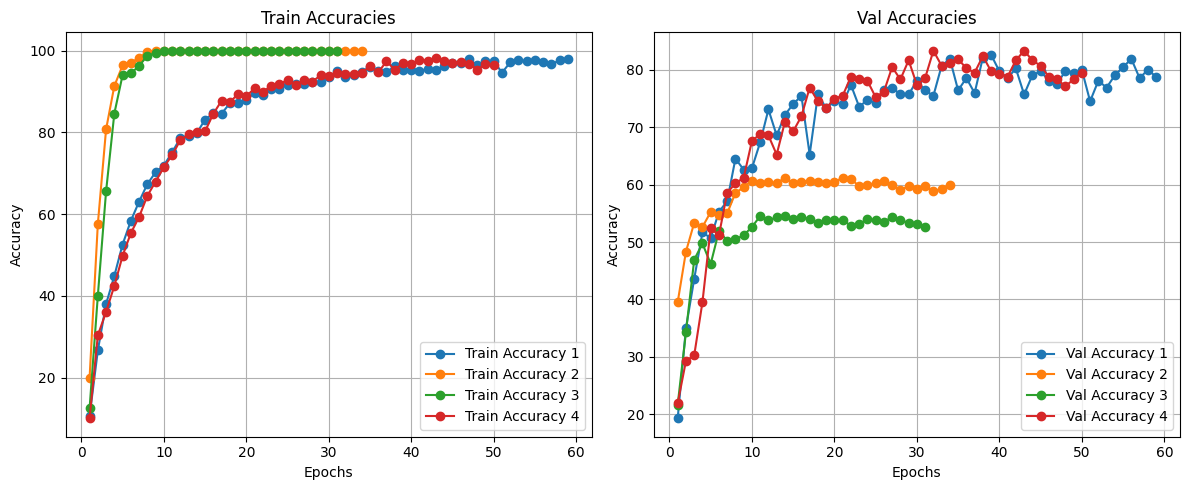

----------------- Training Results -------------------

Best Validation Accuracy 1: 82.62% at epoch 39

Best Validation Accuracy 2: 61.19% at epoch 14

Best Validation Accuracy 3: 54.52% at epoch 11

Best Validation Accuracy 4: 83.33% at epoch 32


In [40]:
show_comparison_result([train_accuracies_single, train_accuracies_49a, train_accuracies_49b, train_accuracies_49c], [val_accuracies_single, val_accuracies_49a, val_accuracies_49b, val_accuracies_49c])

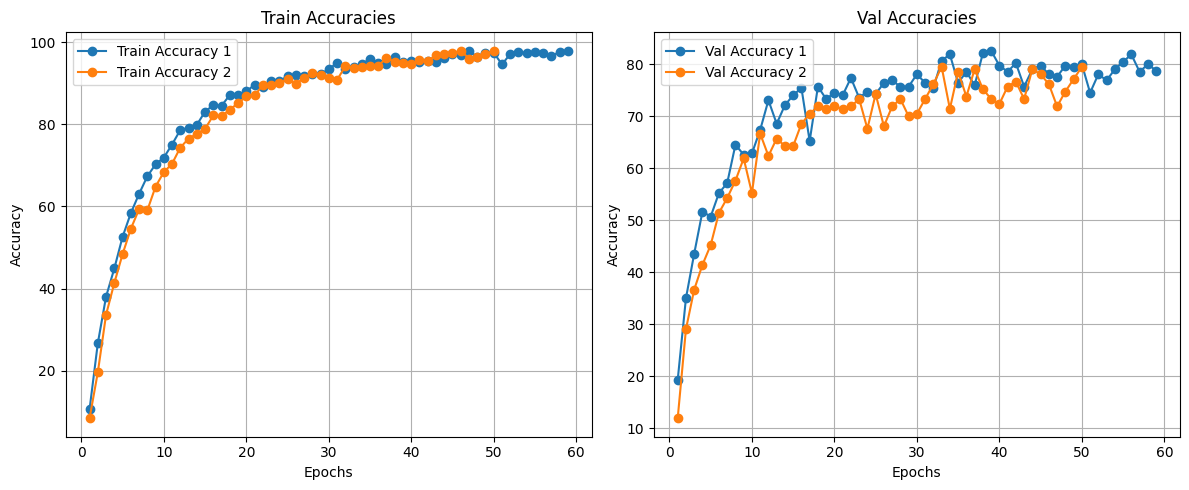

----------------- Training Results -------------------

Best Validation Accuracy 1: 82.62% at epoch 39

Best Validation Accuracy 2: 79.52% at epoch 33


In [41]:
show_comparison_result([train_accuracies_single, train_accuracies_49d], [val_accuracies_single, val_accuracies_49d])

## <span style="color:yellow">**V - Multi Label**</span>

### <span style="color:cyan">1) Load Data

In [37]:
labels_file = './ucmdata/LandUse_Multilabeled.txt'

labels_df = pd.read_csv(labels_file, sep='\t')

dataset_path = "./ucmdata/UCMImages/UCMerced_LandUse/Images"

In [38]:
# Define dataset paths
dataset_path = "./ucmdata/UCMImages/UCMerced_LandUse/Images"

class MultiLabelDataset(Dataset):
    def __init__(self, img_dir, labels_df, transform=None):
        self.img_dir = img_dir
        self.labels_df = labels_df
        self.transform = transform
        self.classes = self.labels_df.columns[1:].tolist()
        self.image_names = self.labels_df.iloc[:, 0]
        self.labels = self.labels_df.iloc[:, 1:].values

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir,self.image_names[idx][:-2], self.image_names[idx] + ".tif")
        image = Image.open(img_name).convert('RGB')

        labels = self.labels[idx].astype('float32')

        if self.transform:
            image = self.transform(image)

        return image, labels

data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

multi_label_dataset = MultiLabelDataset(img_dir=dataset_path, labels_df=labels_df, transform=data_transforms)

data_loader = DataLoader(multi_label_dataset, batch_size=32, shuffle=True)

train_size = int(0.7 * len(multi_label_dataset))
test_size = int(0.2 * len(multi_label_dataset))
valid_size = len(multi_label_dataset) - train_size - test_size
train_dataset, test_dataset, valid_dataset = random_split(multi_label_dataset, [train_size, test_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)
valid_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

# Verify the classes
print(f"Classes: {multi_label_dataset.classes}")
# Number of classes
print(f"Number of classes: {len(multi_label_dataset.classes)}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}")


Classes: ['airplane', 'bare-soil', 'buildings', 'cars', 'chaparral', 'court', 'dock', 'field', 'grass', 'mobile-home', 'pavement', 'sand', 'sea', 'ship', 'tanks', 'trees', 'water']
Number of classes: 17
Number of training samples: 1470
Number of testing samples: 420
Number of validation samples: 210


In [39]:
criterion = nn.BCEWithLogitsLoss()
threshold = 0.5

In [40]:
def train_one_epoch(model, optimizer):
    # --- Training Phase ---
    model.train()  # Set the model to training mode
    total_loss = 0.0
    correct = 0
    total = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the parameter gradients
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update the weights

        # Track loss and accuracy during training
        total_loss += loss.item() * batch_x.size(0)  # Accumulate batch loss
        predicted_probs = torch.sigmoid(outputs)
        
        # Convert probabilities to binary predictions (0 or 1) based on threshold
        predicted_labels = (predicted_probs > threshold).float()

        # Count correct predictions
        for i in range(len(predicted_labels)):
            if torch.equal(predicted_labels[i], batch_y[i]):
                correct += 1
        total += len(predicted_labels)  # Total number of labels (batch_size * num_classes)


    avg_train_loss = total_loss / total
    train_accuracy = 100 * correct / total

    return avg_train_loss, train_accuracy

In [41]:
def evaluate_model(model):
    # --- Validation Phase ---
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for batch_x, batch_y in valid_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass (no gradient calculation)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            # Track loss and accuracy during validation
            val_loss += loss.item() * batch_x.size(0)
            predicted_probs = torch.sigmoid(outputs)
            
            # Convert probabilities to binary predictions (0 or 1) based on threshold
            predicted_labels = (predicted_probs > threshold).float()

            # Count correct predictions
            # correct_val += (predicted_labels == batch_y).sum().item()
            for i in range(len(predicted_labels)):
                if torch.equal(predicted_labels[i], batch_y[i]):
                    correct_val += 1
            total_val += len(predicted_labels)  # Total number of labels (batch_size * num_classes)

    avg_val_loss = val_loss / total_val
    val_accuracy = 100 * correct_val / total_val

    return avg_val_loss, val_accuracy

### <span style="color:cyan">2) Model

In [42]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=17):
        super(CNNModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), # 16x256x256
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16x128x128
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # 32x128x128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32x64x64
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # 64x64x64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64x32x32
            nn.Flatten()
        )

        self.num_features = 128 * 32 * 32

        self.classifier = nn.Sequential(
            nn.Linear(self.num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        
        x = self.features(x)

        x = self.classifier(x)

        return x

In [43]:
NUM_EPOCH = 20
PATIENCE = 20
train_accuracies_multi,\
train_loss_multi,\
val_accuracies_multi,\
val_loss_multi,\
model_multi = initialize_and_train(CNNModel(), save=True)

Training model: CNNModel
Number of parameters: 67211345
Number of layers: 2
Architecture of the model: 
CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=131072, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=17, bias=True)
  )
)


Initialization...
Initialization complete. Starting training...



-----

C:\Users\remij\AppData\Local\Temp\ipykernel_2140\2968688044.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


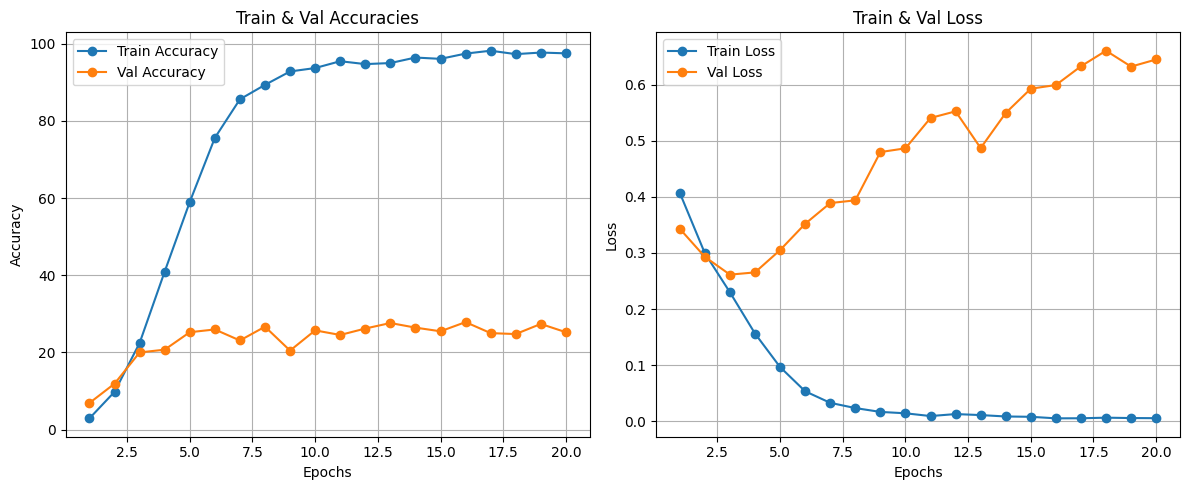

----------------- Training Results -------------------
Final Training Accuracy: 97.48%
Final Validation Accuracy: 25.24%
Final Training Loss: 0.0052
Final Validation Loss: 0.6452

Best Validation Accuracy: 27.86% at epoch 16


In [71]:
show_training_result(train_accuracies_multi, train_loss_multi, val_accuracies_multi, val_loss_multi)

### <span style="color:cyan">3) Testing

In [66]:
def test_model_multilabel(model, threshold=0.36):
    # --- Test Phase ---
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    # matrix num_class x 2 for true positives, false positives, etc.
    classification_results = np.zeros((len(multi_label_dataset.classes), 2))  # 2 columns: [correct, incorrect]

    # number_of_necessary_labels = 0
    # number_of_predicted_labels = 0

    print("----------------- Testing -------------------")

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # Forward pass (aucun calcul de gradient)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            # Suivi de la perte et de l'exactitude
            test_loss += loss.item() * batch_x.size(0)

            # Apply sigmoid to get probabilities, and threshold to get binary predictions
            outputs = torch.sigmoid(outputs)
            predicted = (outputs >= threshold).float()

            # classification matrix
            for i in range(len(predicted)):
                for j in range(len(multi_label_dataset.classes)):
                    if batch_y[i][j] == predicted[i][j]:
                        classification_results[j][0] += 1
                    else:  # Incorrect prediction
                        classification_results[j][1] += 1

            # number_of_necessary_labels += batch_y.sum().item()
            # number_of_predicted_labels += predicted.sum().item()

            # Compare for exact match accuracy (if all labels are correct for a sample)
            correct_test += ((predicted == batch_y).all(dim=1)).sum().item()
            total_test += batch_y.size(0)

    avg_test_loss = test_loss / total_test if total_test != 0 else 0
    test_accuracy = 100 * correct_test / total_test if total_test != 0 else 0

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print(f"Correctly classified samples: {correct_test}/{total_test}")

    return avg_test_loss, test_accuracy, classification_results


In [64]:
avg_test_loss_multi, test_accuracy_multi, classification_multi = test_model_multilabel(model_multi)

----------------- Testing -------------------
Test Loss: 0.5174, Test Accuracy: 30.95%
Correctly classified samples: 130/420


In [82]:
def plot_classification_results(classification_results, class_labels):
    correct = classification_results[:, 0]  # True Positives
    incorrect = classification_results[:, 1]  # False Positives/Negatives
    
    # Define the x-axis positions for each class
    x = np.arange(len(class_labels))
    
    # Create the stacked bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the bars: correct classifications and incorrect classifications
    ax.bar(x, correct, label='Correct Classifications', color='g')
    ax.bar(x, incorrect, bottom=correct, label='Incorrect Classifications', color='r')
    
    # Add title and labels
    ax.set_title('Classification Results: Correct vs Incorrect Predictions', fontsize=14)
    ax.set_xlabel('Classes', fontsize=12)
    ax.set_ylabel('Number of Samples', fontsize=12)
    
    # Add x-ticks labels (class names)
    ax.set_xticks(x)
    ax.set_xticklabels(class_labels, rotation=45, ha='right', fontsize=10)
    
    # Add legend
    ax.legend(loc='upper right')
    
    # Add grid for better readability
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Show plot
    plt.tight_layout()
    plt.show()


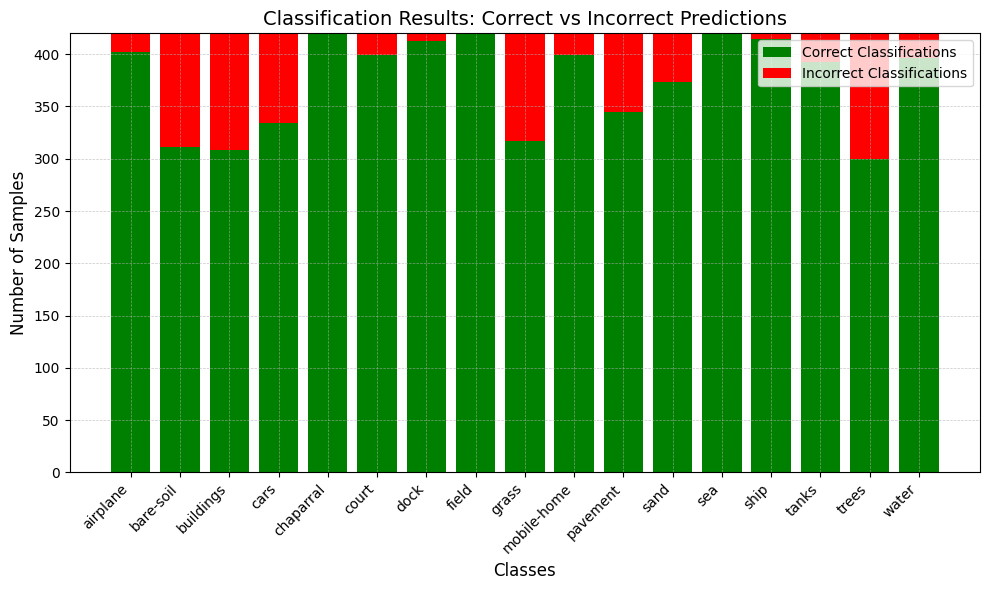

In [83]:
plot_classification_results(classification_multi, multi_label_dataset.classes)

## <span style="color:yellow">**VI - ResNet Single Label**</span>

In [79]:
# Load pre-trained ResNet model
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 21)

In [80]:
NUM_EPOCH = 50
PATIENCE = 20
train_accuracies_resnet, train_loss_resnet, val_accuracies_resnet, val_loss_resnet, model_resnet = initialize_and_train(model)

Training model: ResNet
Number of parameters: 23551061
Number of layers: 10
Architecture of the model: 
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inp

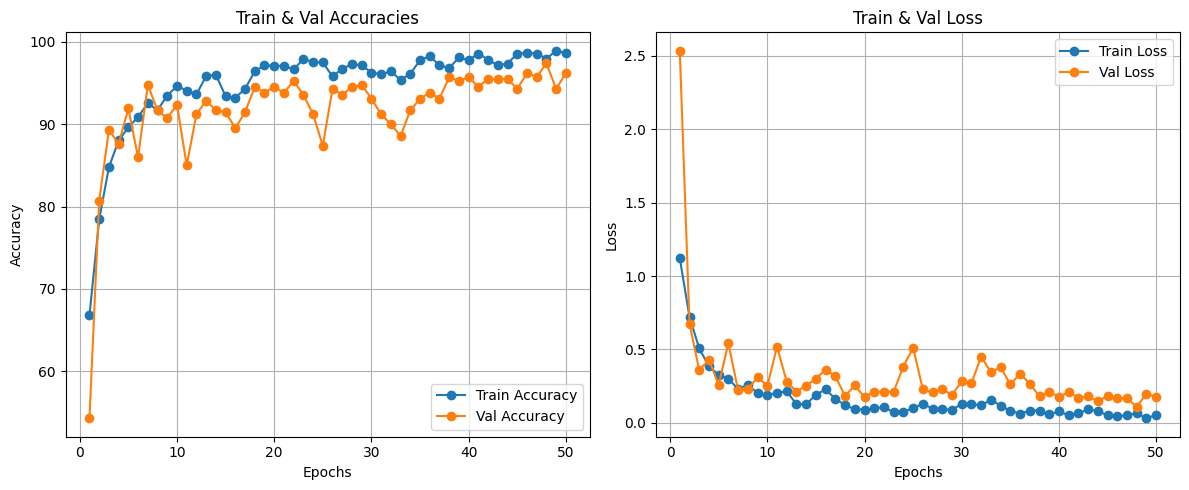

----------------- Training Results -------------------
Final Training Accuracy: 98.64%
Final Validation Accuracy: 96.19%
Final Training Loss: 0.0542
Final Validation Loss: 0.1774

Best Validation Accuracy: 97.38% at epoch 48


In [81]:
show_training_result(train_accuracies_resnet, train_loss_resnet, val_accuracies_resnet, val_loss_resnet)

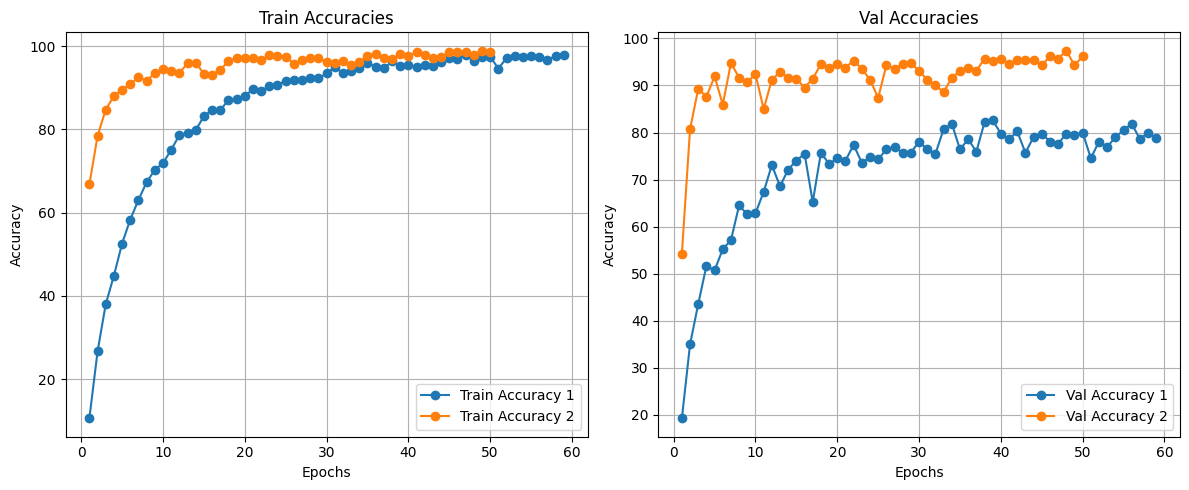

----------------- Training Results -------------------

Best Validation Accuracy 1: 82.62% at epoch 39

Best Validation Accuracy 2: 97.38% at epoch 48


In [82]:
show_comparison_result([train_accuracies_single, train_accuracies_resnet], [val_accuracies_single, val_accuracies_resnet])

In [84]:
avg_test_loss_resnet, test_accuracy_resnet, classification_results_resnet = test_model(model_resnet)

----------------- Testing -------------------
Test Loss: 0.1652, Test Accuracy: 96.67%
Correctly classified samples: 406/420


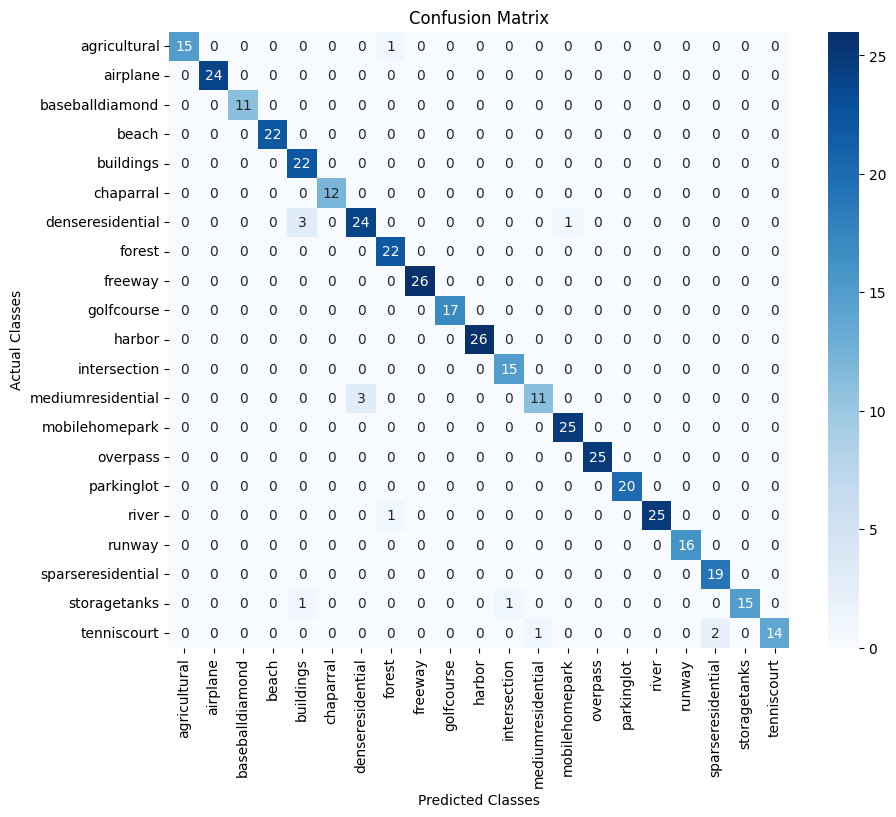

In [85]:
plot_confusion_matrix(classification_results_resnet, class_names)

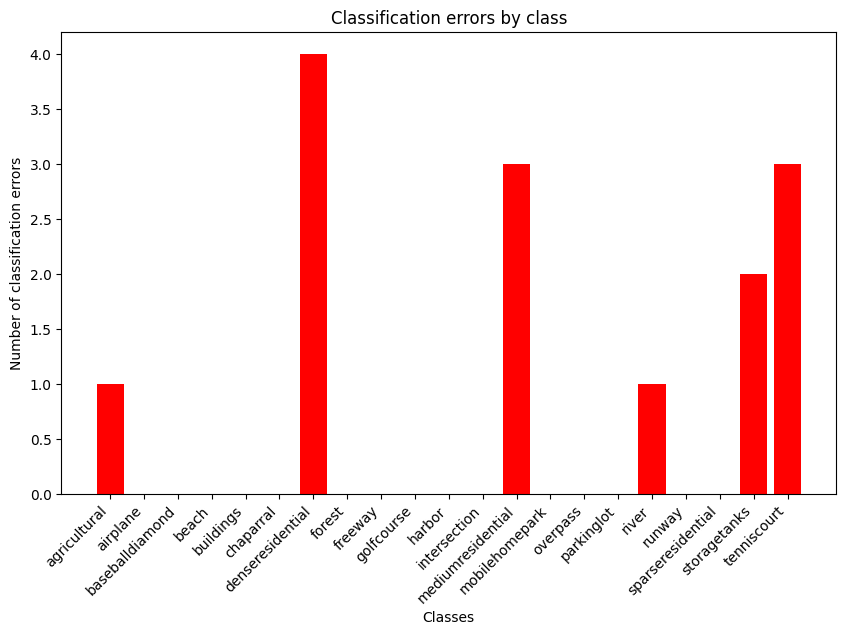

In [86]:
plot_classification_errors(classification_results_resnet, class_names)

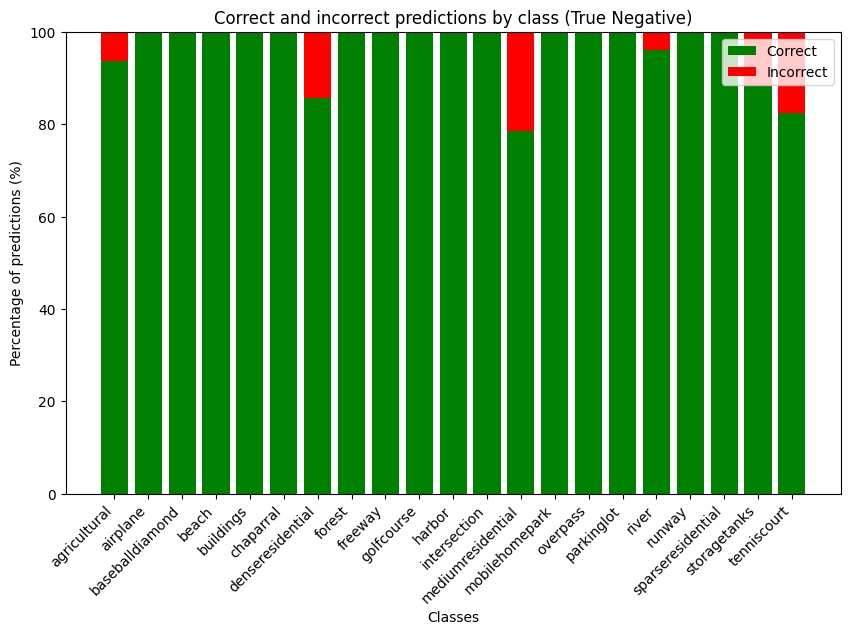

In [87]:
plot_correct_incorrect_predictions(classification_results_resnet, class_names)


False positives by class:
agricultural: 0.0
airplane: 0.0
baseballdiamond: 0.0
beach: 0.0
buildings: 15.38
chaparral: 0.0
denseresidential: 11.11
forest: 8.33
freeway: 0.0
golfcourse: 0.0
harbor: 0.0
intersection: 6.25
mediumresidential: 8.33
mobilehomepark: 3.85
overpass: 0.0
parkinglot: 0.0
river: 0.0
runway: 0.0
sparseresidential: 9.52
storagetanks: 0.0
tenniscourt: 0.0


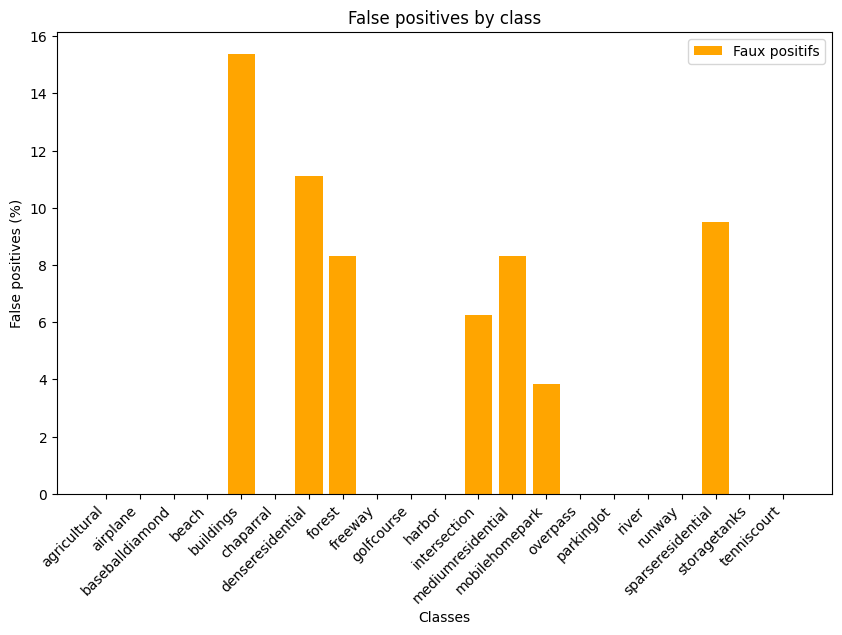

In [88]:
display_false_positives(classification_results_resnet, class_names)

## <span style="color:yellow">**VII - Resnet Multi-label**</span>

In [84]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 17)

c:\Users\remij\Documents\IG5\DSA\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\remij\Documents\IG5\DSA\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [86]:
NUM_EPOCH = 20
PATIENCE = 20
train_accuracies_multi,\
train_loss_multi,\
val_accuracies_multi,\
val_loss_multi,\
model_multi = initialize_and_train(model, save=True)

Training model: ResNet
Number of parameters: 23542865
Number of layers: 10
Architecture of the model: 
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inp

C:\Users\remij\AppData\Local\Temp\ipykernel_14524\2968688044.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


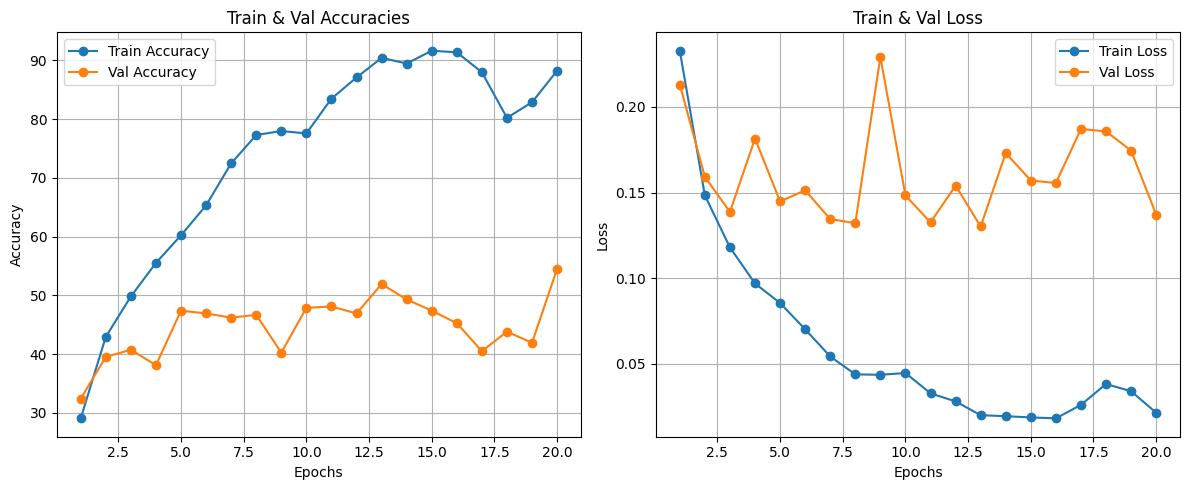

----------------- Training Results -------------------
Final Training Accuracy: 88.23%
Final Validation Accuracy: 54.52%
Final Training Loss: 0.0214
Final Validation Loss: 0.1371

Best Validation Accuracy: 54.52% at epoch 20


In [87]:
show_training_result(train_accuracies_multi, train_loss_multi, val_accuracies_multi, val_loss_multi)

In [88]:
avg_test_loss_multi, test_accuracy_multi, classification_multi = test_model_multilabel(model_multi)

----------------- Testing -------------------
Test Loss: 0.1371, Test Accuracy: 54.52%
Correctly classified samples: 229/420


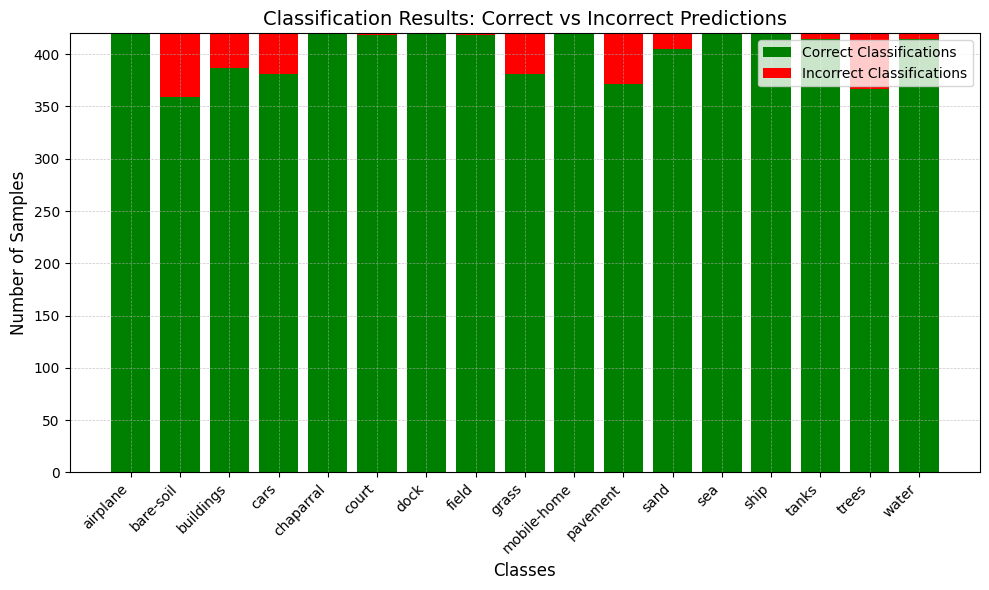

In [89]:
plot_classification_results(classification_multi, multi_label_dataset.classes)